In [34]:
import torchvision
import torch
import numpy as np
import os
import PIL.Image 
from PIL import Image


import time
import copy
import seaborn as sn
import pandas as pd
import sklearn.metrics
from matplotlib import pyplot as plt
from math import ceil
import gc
from tqdm import tqdm

In [35]:
torch.manual_seed(0)
np.random.seed(0)

In [36]:
class OstVisDataset(torch.utils.data.Dataset):
    def __init__(self, roots, transforms, subset, label_map, exclude_subfolders = None, split = (.6,.2,.2)):
        # list of root folders
        self.roots = roots

        # list of subfolders to exclude from sampling (e.g. if you only want control_well 1 and adipogenic differentiation)
        self.exclude_subfolders = exclude_subfolders

        # torchvision composed transforms
        self.transforms = transforms

        # dict mapping subfolder names to labels
        self.label_map = label_map

        # getting files
        self.enumerated_files = self.depthwise_enumerate(subset,split)


    def depthwise_enumerate(self, subset, split): 
        all_files = []
        # for each root folder
        for i in self.roots:
            # get subfolders
            folders = [i + "/" + f for f in os.listdir(i) if '.' not in f]
            folders = [folder + "/" for folder in folders]
            
            if self.exclude_subfolders:
                folders = [f for f in folders if f.lower() not in self.exclude_subfolders]

            for j in folders:
                # get files from folders
                files = ["/" + j + g for g in os.listdir(j) if ".stk" in g]

                # copy files list
                files_copy = files.copy()

                # calculate sample size then select the proper subset
                train_size = ceil(len(files) * split[0])
                
                if subset == 'train':
                    upper_bound = train_size
                    files = files_copy[:upper_bound]
                elif subset == 'valid': 
                    lower_bound = train_size
                    upper_bound = train_size + ceil(len(files) * split[1])
                    files = files_copy[lower_bound:upper_bound]
                else:
                    lower_bound = train_size + ceil(len(files) * split[1])
                    files = files_copy[lower_bound:]
                
                # extend all files list by the file list for subfolder j
                all_files.extend(files)
        
        # return flat list of files
        return all_files
    
    def __len__(self):
        return len(self.enumerated_files)
    
    def __getitem__(self, idx):
        # check type
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # get image at position idx in enumerated list
        image_path = str(os.getcwd() + self.enumerated_files[idx])
        image = PIL.Image.open(image_path).convert('RGB')
        
        # apply tranforms
        image = self.transforms(image)
        
        # separate subfolder name from path
        image_path_parts = image_path.replace("\\","/")
        image_path_parts = image_path_parts.split('/')

        # determine label
        label = self.label_map[image_path_parts[4].lower()]
        
        # return ((path, image), output) pair We will use path to track accuracy for each class: 7 day, 10 day, etc
        return ((image_path_parts[0], image), label)

In [37]:
def load_model(device):
    model_ft = torchvision.models.resnet101(weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V2)
    num_ftrs = model_ft.fc.in_features


    model_ft.fc = torch.nn.Linear(num_ftrs, 2)

    model_ft = model_ft.to(device)

    criterion = torch.nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    return model_ft, criterion, exp_lr_scheduler, optimizer_ft

def train_model(model, criterion, optimizer, scheduler, device, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_epoch_accuracies = []
    val_epoch_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)


        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            num_positives = 0


            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs[1].to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_positives = torch.count_nonzero(labels.data)
                true_positive_rate = torch.sum(preds == labels.data)
                print(preds * labels.data)
                

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_epoch_accuracies.append(float(epoch_acc))
            if phase == 'valid':
                val_epoch_accuracies.append(float(epoch_acc))
                
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid acc: {best_acc:4f}')
    plt.plot([i + 1 for i in range(num_epochs)], train_epoch_accuracies, label='Train')
    plt.plot([i + 1 for i in range(num_epochs)], val_epoch_accuracies, label = 'Validation')
    plt.legend()
    plt.xlabel('Epoch', fontname='Arial', fontsize = 12)
    plt.ylabel('Accuracy', fontname='Arial', fontsize = 12)
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def retrieve_label(filename):
    # obtains key
    key = filename.split(datasets['train'].roots[0]+"/",1)[1].split("/",1)[0]
    value = datasets['train'].label_map[key]
    return key, value

# combines R,G,B into one image (redundant?)
def merge_channels(dataset):
    merged_tensors = []
    arr = []
    for i in range(int(len(dataset)/4)):
        filename = dataset.enumerated_files[4*i]
        for j in range(4):
            arr.insert(j,dataset[4 * i + j][0][1]) 
        merged_tensors.insert(i,arr)
        arr = []

    return merged_tensors

# this does *not* do what i originally thought
def patched_channels(dataset):
    patched_tensors = []
    arr = []
    for i in range(int(len(dataset)/4)):
        arr_idx = 4*i
        filename = dataset.enumerated_files[arr_idx]
        arr = dataset[arr_idx][0][1] + dataset[arr_idx+1][0][1] + dataset[arr_idx+2][0][1] + dataset[arr_idx+3][0][1]
        
    patched_tensors.insert(i,arr)
    return patched_tensors


In [39]:
# initial construction of torch Dataset object
split_names = ['train', 'valid', 'test']


label_map = {
    # 0 = benign
    # 1 = malignant
    '02tumor' : 1,
#   '03tumor' : 0, 
    '04tumor' : 1, 
    '05tumor' : 0, 
    '06tumor' : 0,
#   '07tumor' : 0, # mixed case, primarily 1
#   '08tumor' : 0, 
    '09tumor' : 1,
#   '10tumor' : 0,
    '11tumor' : 1,
    '12tumor' : 0, 
    '13tumor' : 0, 
    '14tumor' : 0,
    '15tumor' : 0,
    '16tumor' : 1, 
    '17tumor' : 1, 
    '18tumor' : 1,
    '19tumor' : 1,
    '20tumor' : 0,
    '21tumor' : 1, 
    '22tumor' : 1, 
    '23tumor' : 0, 
    '24tumor' : 1,
    '25tumor' : 0, 
    '26tumor' : 0, 
#   '27tumor' : 1,
    '28tumor' : 1,
    '29tumor' : 0,
#   '30tumor' : 1, 
    '31tumor' : 0
}

data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.Resize(200),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': torchvision.transforms.Compose([
        torchvision.transforms.Resize(200),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': torchvision.transforms.Compose([
        torchvision.transforms.Resize(200),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


datasets = {split: OstVisDataset(roots = ['Data - Full'],
                      transforms= data_transforms[split],
                      subset= split,
                      label_map = label_map,
                      exclude_subfolders=['split'],
                      split=(.6,.2,.2)) 
                      for split in split_names
            }

for i in datasets['train'].enumerated_files:
    if i in datasets['valid'].enumerated_files or i in datasets['test'].enumerated_files:
        print('Duplicate Found: ', i)

for i in datasets['valid'].enumerated_files:
    if i in datasets['train'].enumerated_files or i in datasets['test'].enumerated_files:
        print('Duplicate Found: ', i)

# constructing dataloaders
dataloaders = {split : torch.utils.data.DataLoader(datasets[split], shuffle=True, batch_size=128, num_workers=0) for split in split_names}

# getting lens
dataset_sizes = {split : len(datasets[split]) for split in split_names}
print(dataset_sizes)

# constructing device
device = torch.device("cpu")

# load model
model_ft, criterion, exp_lr_scheduler, optimizer_ft = load_model(device)

print('Train files:', datasets['train'].enumerated_files)
print('Validation files:', datasets['valid'].enumerated_files)
print('Testing files:', datasets['test'].enumerated_files)

{'train': 716, 'valid': 248, 'test': 217}
Train files: ['/Data - Full/02tumor/25x_Ta_power2_stepsize1_PMT700_Ch1.stk', '/Data - Full/02tumor/25x_Ta_power2_stepsize1_PMT700_Ch2.stk', '/Data - Full/02tumor/25x_Ta_power2_stepsize1_PMT700_Ch3.stk', '/Data - Full/02tumor/25x_Ta_power2_stepsize1_PMT700_Ch4.stk', '/Data - Full/02tumor/25x_Ta_power2_stepsize1_PMT700_Color Combine.stk', '/Data - Full/02tumor/25x_Ta_power2_stepsize1_PMT700_Color Combine_24bits.stk', '/Data - Full/02tumor/25x_Ta_power2_stepsize1_PMT700_zoom2_kalman3_Ch1.stk', '/Data - Full/02tumor/25x_Ta_power2_stepsize1_PMT700_zoom2_kalman3_Ch2.stk', '/Data - Full/02tumor/25x_Ta_power2_stepsize1_PMT700_zoom2_kalman3_Ch3.stk', '/Data - Full/02tumor/25x_Ta_power2_stepsize1_PMT700_zoom2_kalman3_Ch4.stk', '/Data - Full/02tumor/25x_Ta_power2_stepsize1_PMT700_zoom2_kalman3_Color Combine.stk', '/Data - Full/02tumor/25x_Ta_power2_stepsize1_PMT700_zoom2_kalman3_Color Combine_24bits.stk', '/Data - Full/02tumor/25x_Tb_power1_stepsize1_PMT7

Epoch 0/2
----------
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1

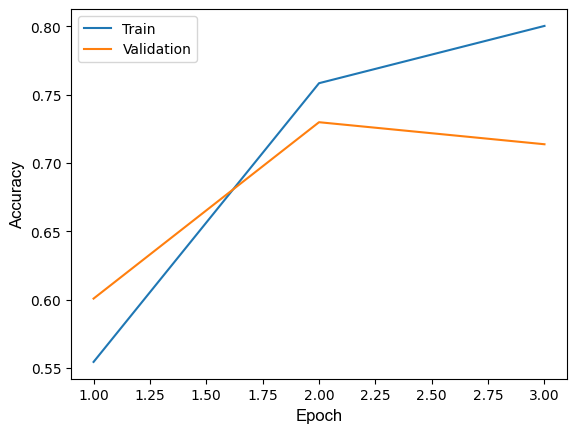

In [40]:
# train model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,device, dataloaders, dataset_sizes,
                       num_epochs=3)

In [41]:
torch.save(model_ft.state_dict(),'model.pth')

model_ft_2 = torchvision.models.vgg19(pretrained=True)
torch.save(model_ft_2.state_dict(),'model.pth')
#np.savetxt('predictions.csv',predictions.numpy(),delimiter=',')   


C:\Users\jwneu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jwneu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
example_transforms = torchvision.transforms.Compose([
   
        #torchvision.transforms.RandomResizedCrop(224),
        #torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = torchvision.transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = example_transforms(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [43]:
# only run this after training
torch.save(model_ft.state_dict(), 'OCNN_Multiclass_all_days_State_Dict_RESNET50')

In [44]:
# load model from dict
model_ft.load_state_dict(torch.load('OCNN_Multiclass_all_days_State_Dict_RESNET50'))

model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [45]:
true = []
pred = []
pred2 = []
pred_probs = []
pred_probs2 = []

# making predictions
for i in dataloaders['test']:
    true.extend(list(zip([j for j in i[0][0]], [int(j) for j in i[1]])))
    evals = model_ft(i[0][1])
    pred.extend([int(torch.argmax(j)) for j in evals])
    pred_probs.extend([torch.softmax(j, 0).detach().numpy() for j in evals])

# separating class label from filename 
true_numeric = [i[1] for i in true]
#true_numeric2 = [i[1] for i in true]


# overall metrics

print('Overall Accuracy: ', sklearn.metrics.accuracy_score(true_numeric, pred))
#print('Overall One vs Rest AUC: ', sklearn.metrics.roc_auc_score(true_numeric, pred_probs, multi_class='ovr', average='weighted'))

Overall Accuracy:  0.6774193548387096


<Axes: >

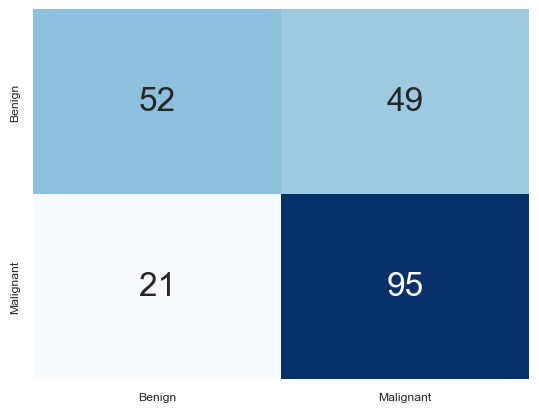

In [46]:
# labels for visual
class_names = ['Benign', 'Malignant']

# numeric confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(true_numeric, pred)

# convert to df and make fancy confusion matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names)

sn.set(font_scale = .8)
sn.heatmap(confusion_matrix_df, annot=True, fmt='g', cbar=False, cmap='Blues', annot_kws={'fontsize' : 24})

In [47]:
df = pd.DataFrame(np.column_stack([true_numeric,pred]), columns = ["Actual","Predicted"])
df['Match'] = np.where(df['Actual'] == df['Predicted'],1,0)
#df['Match_2'] = np.where(df['Actual'] == df['Expected_2'],1,0)
#df['Match_Any'] = df['Match_1'] | df['Match_2']
df['Name'] = pd.Series(datasets['test'].enumerated_files)
df.to_csv('example.csv',index=False)

# df.to_csv('example2.csv',index=False)
# df.to_csv('example3.csv',index = False)

df1 = pd.read_csv('example.csv')
#df2 = pd.read_csv('example2.csv')

#matched_pairs = df1.iloc[3] == df2.iloc[3]

In [48]:
a = pd.DataFrame(np.array(pred_probs))
a.to_csv('ex1.csv')

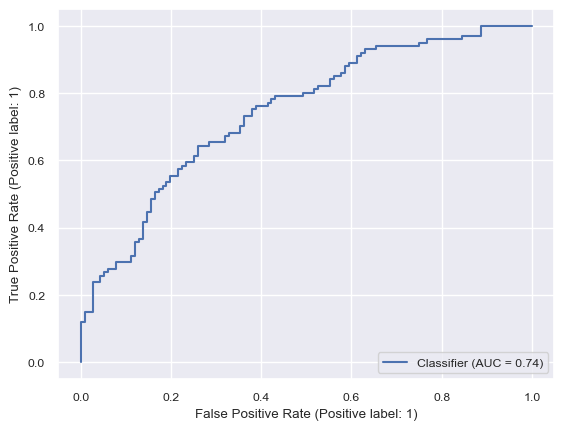

In [49]:
control_vs_rest_true = [1 if i == 0 else 0 for i in true_numeric]
display = sklearn.metrics.RocCurveDisplay.from_predictions(control_vs_rest_true, np.array(pred_probs)[:,0])

fpr = display.fpr
tpr = display.tpr


# Create a dictionary to store the data
roc_data = {
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}

# Convert the dictionary to a Pandas DataFrame
roc_df = pd.DataFrame(roc_data)
roc_df.to_csv("roc.csv")


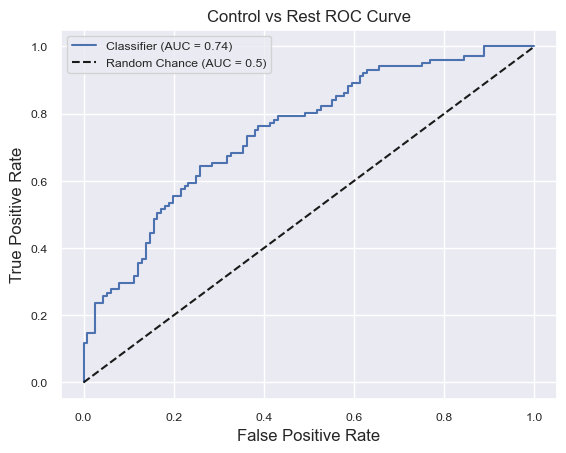

In [50]:
# Control vs Rest roc curve
control_vs_rest_true = [1 if i == 0 else 0 for i in true_numeric]
sklearn.metrics.RocCurveDisplay.from_predictions(control_vs_rest_true, np.array(pred_probs)[:,0])
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.5)')
plt.title('Control vs Rest ROC Curve', fontname='Arial', fontsize = 12)
plt.xlabel('False Positive Rate', fontname='Arial', fontsize = 12)
plt.ylabel('True Positive Rate', fontname='Arial', fontsize = 12)
plt.legend()

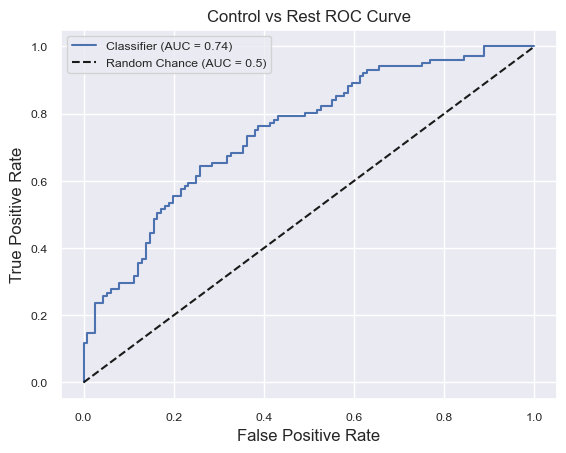

In [51]:
control_vs_rest_true = [1 if i == 0 else 0 for i in true_numeric]
sklearn.metrics.RocCurveDisplay.from_predictions(control_vs_rest_true, np.array(pred_probs)[:,0])
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.5)')
plt.title('Control vs Rest ROC Curve', fontname='Arial', fontsize = 12)
plt.xlabel('False Positive Rate', fontname='Arial', fontsize = 12)
plt.ylabel('True Positive Rate', fontname='Arial', fontsize = 12)
plt.legend()

In [ ]:
# computing metrics by class

all = []

for i in zip(true, pred, pred_probs):
    # basically flattening the true and pred class. i[0][0] is filename, i[0][1] is true class, i[1] is prediction
    all.append((i[0][0], i[0][1], i[1], i[2]))

# convert to dataframe for easy slicing
all_preds_and_labels = pd.DataFrame(all, columns=['File Group', 'True Class', 'Prediction', 'Predicted Probs'])
metrics_dict = dict()


# compute metrics for each filename
for i in set(all_preds_and_labels['File Group']):
    slice = all_preds_and_labels[all_preds_and_labels['File Group'] == i]
    metrics_dict['{} Accuracy'.format(i)] = sklearn.metrics.accuracy_score(np.array(slice['True Class']), np.array(slice['Prediction']))
    
for i in metrics_dict.items():
    print(i)

('d: Accuracy', 0.6774193548387096)


In [53]:
true_train = []

for i in dataloaders['train']:
    true_train.extend(list(zip([j for j in i[0][0]], [int(j) for j in i[1]], [j for j in range(len(i[1]))])))
print(true_train)
all_train_labels = pd.DataFrame(true_train, columns=['File Group', 'True Class', 'ID'])

[('d:', 0, 0), ('d:', 1, 1), ('d:', 1, 2), ('d:', 1, 3), ('d:', 0, 4), ('d:', 0, 5), ('d:', 0, 6), ('d:', 1, 7), ('d:', 1, 8), ('d:', 1, 9), ('d:', 1, 10), ('d:', 0, 11), ('d:', 1, 12), ('d:', 1, 13), ('d:', 0, 14), ('d:', 1, 15), ('d:', 1, 16), ('d:', 1, 17), ('d:', 1, 18), ('d:', 0, 19), ('d:', 1, 20), ('d:', 1, 21), ('d:', 0, 22), ('d:', 1, 23), ('d:', 0, 24), ('d:', 1, 25), ('d:', 1, 26), ('d:', 1, 27), ('d:', 0, 28), ('d:', 1, 29), ('d:', 1, 30), ('d:', 1, 31), ('d:', 0, 32), ('d:', 1, 33), ('d:', 0, 34), ('d:', 0, 35), ('d:', 1, 36), ('d:', 1, 37), ('d:', 0, 38), ('d:', 1, 39), ('d:', 0, 40), ('d:', 0, 41), ('d:', 1, 42), ('d:', 0, 43), ('d:', 0, 44), ('d:', 1, 45), ('d:', 0, 46), ('d:', 1, 47), ('d:', 0, 48), ('d:', 1, 49), ('d:', 0, 50), ('d:', 1, 51), ('d:', 1, 52), ('d:', 1, 53), ('d:', 0, 54), ('d:', 0, 55), ('d:', 1, 56), ('d:', 1, 57), ('d:', 0, 58), ('d:', 1, 59), ('d:', 1, 60), ('d:', 1, 61), ('d:', 0, 62), ('d:', 0, 63), ('d:', 0, 64), ('d:', 0, 65), ('d:', 0, 66), ('d:

In [54]:
test_label_counts = all_preds_and_labels.groupby(['True Class', 'File Group']).count()
print(test_label_counts)

                       Prediction  Predicted Probs
True Class File Group                             
0          d:                 101              101
1          d:                 116              116


In [55]:
train_label_counts = all_train_labels.groupby(['True Class', 'File Group']).count()
print(train_label_counts)

                        ID
True Class File Group     
0          d:          335
1          d:          381


In [ ]:
aex = pd.read_csv('example.csv')